# Discrete distribution

The model is $P_{\theta} = \text{Cat}(\pi)$, with $K=50$ classes and $\pi\in\Delta^{49}$. Based on observations iteratively, $\pi$ is estimated as sample proportions and synthetic samples generated from $\text{Cat}(\hat{\pi})$. We study $E\Vert \hat{\pi}_t - \pi_0\Vert_2^2$ to measure estimation quality over iterations $t$.

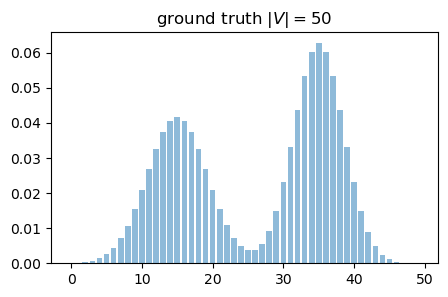

In [1]:
import numpy as np
import matplotlib.pyplot as plt

K = 50
peaks = [15, 35]

model0 = np.ones(K)
for k in range(K):
    model0[k] = 0.4 * np.exp(-(k-peaks[0])**2 / 36) + 0.6 * np.exp(-(k-peaks[1])**2 / 25)

model0 = model0 / model0.sum()

fig, ax = plt.subplots(figsize=(5,3))
plt.bar(range(K), model0, alpha=0.5)
plt.title('ground truth $|V|=50$')
plt.show()

In [2]:
def fit(X):
    '''
    X is of shape (K,)
    '''
    return X / X.sum()

def dist(model1, model2):
    '''
    models are pi
    '''
    
    return np.sum(np.square(model1 - model2))

def plot_avg(loss, ax, plot_traces=True):
    mean = np.mean(loss, axis=0)
    var = np.var(loss, axis=0)
    if plot_traces:
        for i in range(len(loss)):
            ax.plot(range(loss.shape[1]), loss[i], color='yellow', alpha=0.1)
    ax.plot(range(loss.shape[1]), mean)

## Simulation Setups

We conduct 8 experiments:

No fresh data
1. $n_t=20$, $\alpha_t=0$, no accumulation
2. $n_t=20 t$, $\alpha_t=0$, no accumulation
3. $n_t=20 t^{3/2}$, $\alpha_t=0$, no accumulation
4. $n_t=20$, $\alpha_t=0$, accumulation over all past models

Fresh data

5. $n_t=20t$, $\alpha_t=0.1/t$, no accumulation
6. $n_t=20t$, $\alpha_t=0.1/t^{1/2}$, no accumulation
7. $n_t=20t$, $\alpha_t=0.1/t^{1/3}$, no accumulation
7. $n_t=20t$, $\alpha_t=0.1$, no accumulation

In [3]:
n0 = 20

def iterative_discrete(setting, T=100):
    nt_ = setting['nt_'] # n_t = n0 * (1+t)**nt_
    alpha0 = setting['alpha0']
    at_ = setting['at_'] # alpha_t = alpha0 / (1+t)**at_
    accu = setting['accu'] # True or False
    
    # first iteration
    X = np.random.multinomial(n0, model0)
    model = fit(X)

    loss = [dist(model0, model)]
    
    for t in range(T-1):
        n = int(n0 * (1+t)**nt_)
        alpha = alpha0 / (1+t)**at_
        
        if alpha > 0:
            prop = np.array([alpha, 1-alpha])
            m = np.random.multinomial(n, prop)
            if m[0]>0 and m[1]>0:
                X0 = np.random.multinomial(m[0], model0)
                X_ = np.random.multinomial(m[1], model)
                X1 = X0 + X_
            elif m[1]>0:
                X1 = np.random.multinomial(m[1], model)
            elif m[0]>0:
                X1 = np.random.multinomial(m[0], model0)
        else:
            X1 = np.random.multinomial(n, model)
            
        if accu:
            X = X + X1
            model = fit(X)
        else:
            model = fit(X1)
        loss.append(dist(model0, model))
    return loss

settings = [
    {'nt_': 0, 'alpha0': 0, 'at_': 0, 'accu': False},
    {'nt_': 1, 'alpha0': 0, 'at_': 0, 'accu': False},
    {'nt_': 1.5, 'alpha0': 0, 'at_': 0, 'accu': False},
    {'nt_': 0, 'alpha0': 0, 'at_': 0, 'accu': True},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 1, 'accu': False},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 0.5, 'accu': False},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 0.33, 'accu': False},
    {'nt_': 1, 'alpha0': 0.1, 'at_': 0, 'accu': False}
]

In [4]:
reps = 500
T=200

from tqdm import tqdm
from joblib import Parallel, delayed

losses = np.zeros((len(settings), reps, T))

for i, setting in enumerate(settings):
    results = Parallel(n_jobs=-1)(delayed(iterative_discrete)(setting=setting, T=T) for j in range(reps))
    losses[i] = np.array([results[j] for j in range(reps)])
    print(f'setting {i+1} done')

setting 1 done
setting 2 done
setting 3 done
setting 4 done
setting 5 done
setting 6 done
setting 7 done
setting 8 done


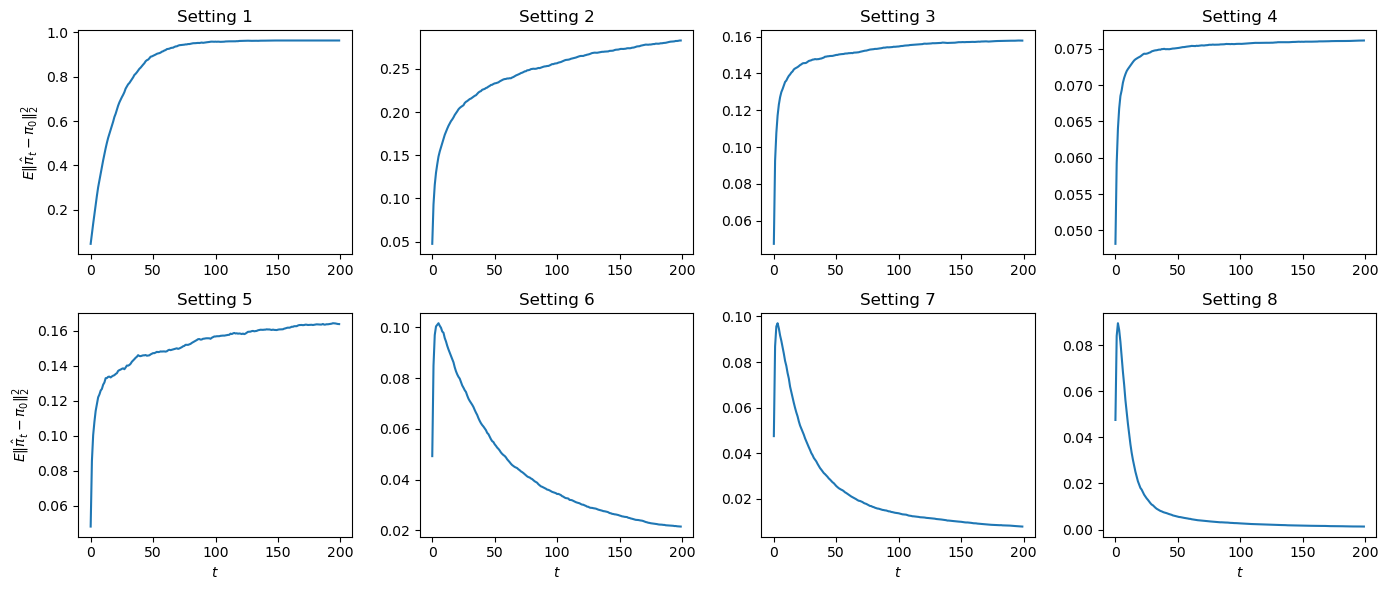

In [5]:
fig, ax = plt.subplots(nrows=2, ncols=4, figsize=(14, 6))

for r in range(2):
    for c in range(4):
        plot_avg(losses[4*r+c], ax[r,c], plot_traces=False)
        ax[r,c].set_title(f'Setting {4*r+c+1}')
ax[0,0].set_ylabel('$E\Vert \hat{\pi}_t - \pi_0\Vert_2^2$')
ax[1,0].set_ylabel('$E\Vert \hat{\pi}_t - \pi_0\Vert_2^2$')

for i in range(4):
    ax[1,i].set_xlabel('$t$')
plt.tight_layout()
plt.show()